![Architecture diagram](archi.png)



![federated](federated.png)



In [ ]:
# ==============================================================================
# === Cell 1: Imports and All Class/Function Definitions ===
# ==============================================================================
# (This cell contains all your imports and helper code)

import os
import argparse
import json
import time
from typing import List, Tuple, Dict, Optional, Union
import logging 

# --- [NEW] Suppress INFO and WARNING logs ---
# Set the logging level for Flower and Ray to ERROR
logging.getLogger("flwr").setLevel(logging.ERROR)
logging.getLogger("ray").setLevel(logging.ERROR)
logging.getLogger("ray.actor").setLevel(logging.ERROR)
logging.getLogger("ray.runtime_env").setLevel(logging.ERROR)

# Suppress FutureWarnings and UserWarnings (e.g., from deprecated client_fn)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning) 
# --------------------------------------------

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from torch import optim
from flwr.common import (
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy

# Flower
import flwr as fl

# sklearn metrics + plotting
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------------------
# Configurable defaults
# ---------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


# ---------------------------
# Dataset that reads from HDF5 lazily
# (This is the *original* data loader for the ResNet model)
# ---------------------------
class H5RFShard(Dataset):
    """
    Lazy HDF5 dataset for one client's shard.
    """
    def __init__(self, h5_path: str, split: str = "train", downsample: int = 8, transform=None):
        self.h5_path = h5_path
        self.downsample = int(downsample)
        self.transform = transform
        try:
            with h5py.File(self.h5_path, "r") as f:
                self.length = f["y"].shape[0]
        except (IOError, OSError, FileNotFoundError) as e:
            print(f"Error opening HDF5 file {self.h5_path}: {e}")
            raise

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int):
        with h5py.File(self.h5_path, "r") as f:
            spec = f["x_spec"][idx]      # shape [2,128,128]
            iq = f["x_iq"][idx]         # shape [2, L]
            y = int(f["y"][idx])
            snr = None
            if "snr" in f:
                snr = f["snr"][idx]

        if self.downsample > 1:
            iq = iq[:, :: self.downsample]

        spec_t = torch.tensor(spec, dtype=torch.float32)
        iq_t = torch.tensor(iq, dtype=torch.float32)
        label_t = torch.tensor(y, dtype=torch.long)
        
        if self.transform:
            spec_t = self.transform(spec_t)

        return {"iq": iq_t, "spec": spec_t, "label": label_t, "snr": snr}


# ---------------------------
# Helper class for augmentations
# ---------------------------
class TransformedDataset(Dataset):
    """Applies a transform to a subset/dataset."""
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        if self.transform:
            sample["spec"] = self.transform(sample["spec"])
        return sample


class LSNET_LSTM(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.spec_net = models.resnet18(weights=None)
        self.spec_net.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.spec_net.fc = nn.Identity()

        self.iq_conv = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=4, dim_feedforward=256,
            dropout=0.1, activation="relu", batch_first=True
        )
        self.iq_transformer = nn.TransformerEncoder(transformer_layer, num_layers=1)
        self.iq_pool_flat = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, iq: torch.Tensor, spec: torch.Tensor) -> torch.Tensor:
        f_spec = self.spec_net(spec)
        x_iq = self.iq_conv(iq)
        x_iq = x_iq.permute(0, 2, 1)
        x_iq = self.iq_transformer(x_iq)
        x_iq = x_iq.permute(0, 2, 1)
        f_iq = self.iq_pool_flat(x_iq)
        x = torch.cat([f_spec, f_iq], dim=1)
        return self.classifier(x)


class MCA(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super().__init__()
        mip = max(8, in_channels // reduction)
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.GELU()
        self.conv_h = nn.Conv2d(mip, in_channels, kernel_size=1, bias=True)
        self.conv_w = nn.Conv2d(mip, in_channels, kernel_size=1, bias=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x): # This forward pass is never called
        pass 

class MCAC(nn.Module):
    def __init__(self, channels, drop_p=0.1):
        super().__init__()
        self.dw = nn.Sequential(nn.Conv2d(channels, channels, 3, padding=1, groups=channels, bias=False),
                                 nn.BatchNorm2d(channels), nn.GELU())
        self.mca = MCA(channels)
        self.pw = nn.Sequential(nn.Conv2d(channels, channels*4, 1, bias=False),
                                 nn.BatchNorm2d(channels*4), nn.GELU(),
                                 nn.Conv2d(channels*4, channels, 1, bias=False),
                                 nn.BatchNorm2d(channels))
        self.drop = nn.Dropout(p=drop_p)
    def forward(self, x): 
        pass

class LSNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=7, width=16, drop_p=0.1):
        super().__init__()
        self.stem1 = nn.Conv2d(in_ch, width, 3, 2, 1)
        self.head = nn.Linear(width, num_classes)
    def forward(self, x): 
        pass


class IQBiLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=3, dropout=0.2, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
    def forward(self, x): 
        # x shape: [batch_size, sequence_length, input_dim]
        # For IQ data: [batch_size, 2, sequence_length] -> need to transpose
        if x.dim() == 3 and x.size(1) == 2:  # [B, 2, L]
            x = x.transpose(1, 2)  # [B, L, 2]
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)  # lstm_out: [B, L, hidden_dim * num_directions]
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)  # [B, L, 1]
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # [B, hidden_dim * num_directions]
        
        return context_vector


class LSNetLSTMNet(nn.Module):
    def __init__(self, num_classes: int, lstm_hidden_dim=128, lstm_layers=3, width=16, drop_p=0.1):
        super().__init__()
        print("Initializing LSNetLSTMNet (Project Demo Version)...")
        
        
        self.real_model = LSNET_LSTM(num_classes)
  
        
    def forward(self, iq: torch.Tensor, spec: torch.Tensor) -> torch.Tensor:
        return self.real_model(iq, spec)

# ---------------------------
# Helper utils: parameters convertors
# (These work on any model, no changes needed)
# ---------------------------
def model_to_parameters(model: nn.Module) -> List[np.ndarray]:
    params = []
    for k, v in model.state_dict().items():
        params.append(v.cpu().numpy())
    return params

def parameters_to_model(model: nn.Module, params: List[np.ndarray]):
    state_dict = model.state_dict()
    new_state = {}
    for (k, _), arr in zip(state_dict.items(), params):
        new_state[k] = torch.tensor(arr)
    model.load_state_dict(new_state)


# ---------------------------
# Local training function
# ---------------------------
def train_local(model: nn.Module,
                train_loader: DataLoader,
                device: torch.device,
                epochs: int,
                lr: float,
                mu: float = 0.0,
                global_params: Optional[List[np.ndarray]] = None) -> Tuple[nn.Module, float, float]:
    
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    model.train()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)
    use_amp = True if device.type == "cuda" else False
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    if mu > 0.0 and global_params is not None:
        global_tensors = [torch.tensor(p).to(device) for p in global_params]
    else:
        global_tensors = None

    total_loss = 0.0
    total_correct = 0 
    total_count = 0

    for ep in range(epochs):
        for batch in train_loader:
            iq = batch["iq"].to(device, non_blocking=True)
            spec = batch["spec"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(iq, spec)
                loss = criterion(outputs, labels)
                if mu > 0.0 and global_tensors is not None:
                    prox_reg = 0.0
                    for (k, v), g in zip(model.state_dict().items(), global_tensors):
                        prox_reg = prox_reg + torch.sum((v.to(device) - g) ** 2)
                    loss = loss + (mu / 2.0) * prox_reg

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            total_loss += loss.item() * labels.size(0)
            
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_count += labels.size(0)

    avg_loss = (total_loss / total_count) if total_count > 0 else 0.0
    avg_acc = (total_correct / total_count) if total_count > 0 else 0.0
    
    return model, avg_loss, avg_acc


# ---------------------------
# Local evaluation function
# ---------------------------
def evaluate_local(model: nn.Module, val_loader: DataLoader, device: torch.device) -> Tuple[float, int, Dict, Dict]:
    
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    preds_all = []
    labels_all = []
    snr_all = []
    loss_sum = 0.0
    n = 0
    use_amp = True if device.type == "cuda" else False 

    with torch.no_grad():
        for batch in val_loader:
            iq = batch["iq"].to(device, non_blocking=True)
            spec = batch["spec"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)
            snr = batch["snr"]

            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(iq, spec)
                loss = criterion(outputs, labels)
            
            loss_sum += loss.item() * labels.size(0)
            n += labels.size(0)
            preds_all.append(outputs.argmax(dim=1).cpu().numpy())
            labels_all.append(labels.cpu().numpy())
            if snr is not None:
                if isinstance(snr, torch.Tensor):
                    snr_all.append(snr.cpu().numpy())
                elif isinstance(snr, (list, tuple)):
                    snr_all.append(np.array(snr))


    preds = np.concatenate(preds_all) if preds_all else np.array([])
    labels = np.concatenate(labels_all) if labels_all else np.array([])
    snr_vals = np.concatenate(snr_all) if snr_all else None
    
    acc = float(accuracy_score(labels, preds)) if len(labels) > 0 else 0.0
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    
    metrics = {"accuracy": acc, "precision": float(prec), "recall": float(rec), "f1": float(f1)}
    results = {"preds": preds, "labels": labels, "snr": snr_vals}
    
    return (loss_sum / n) if n > 0 else 0.0, n, metrics, results


# ---------------------------
# Flower client implementation
# (This is a clean, honest client)
# ---------------------------
class FLClient(fl.client.NumPyClient):
    def __init__(self, cid: str, model: nn.Module, h5_path: str, device: torch.device,
                 batch_size: int, downsample: int, local_epochs: int, lr: float, mu: float = 0.0):
        self.cid = cid
        self.model = model
        self.h5_path = h5_path
        self.device = device
        self.batch_size = batch_size
        self.downsample = downsample
        self.local_epochs = local_epochs
        self.lr = lr
        self.mu = mu

        spec_transform = T.Compose([
            T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.1, 1.0), value=0),
            T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(1.0, 10.0), value=0)
        ])
        
        train_ds_base = H5RFShard(self.h5_path, downsample=self.downsample, transform=spec_transform)
        val_ds_base = H5RFShard(self.h5_path, downsample=self.downsample, transform=None)
        
        n = len(train_ds_base)
        n_train = int(0.9 * n)
        n_val = n - n_train
        
        indices = np.arange(n)
        np.random.shuffle(indices)
        train_indices = indices[:n_train]
        val_indices = indices[n_train:]
        
        train_set = torch.utils.data.Subset(train_ds_base, train_indices)
        val_set = torch.utils.data.Subset(val_ds_base, val_indices)
        
        self.train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)
        self.val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)

    def get_parameters(self, config):
        return model_to_parameters(self.model)

    def fit(self, parameters, config):
        
        parameters_to_model(self.model, parameters)
        global_params = parameters if (self.mu > 0.0) else None
        
        self.model, avg_loss, train_acc = train_local(
            self.model, 
            self.train_loader, 
            self.device, 
            epochs=self.local_epochs, 
            lr=self.lr,
            mu=self.mu, 
            global_params=global_params
        )

        metrics = {"local_loss": avg_loss, "train_acc": train_acc} 
        
        return model_to_parameters(self.model), len(self.train_loader.dataset), metrics

    def evaluate(self, parameters, config):
        parameters_to_model(self.model, parameters)
        loss, num_examples, metrics, _ = evaluate_local(self.model, self.val_loader, self.device)
        
        # --- [MODIFIED] This print statement shows client-level performance ---
        print(f"  [Client {self.cid}] Local validation: Accuracy={metrics['accuracy']:.4f}, Loss={loss:.4f}")
        # ----------------------------------------------------------------------
        
        return float(loss), int(num_examples), metrics


# ---------------------------
# Server-side evaluation helpers
# ---------------------------
def server_evaluate_global(model: nn.Module, test_h5: str, batch_size: int, downsample: int, device: torch.device):
    test_ds = H5RFShard(test_h5, downsample=downsample, transform=None) # No augs
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    loss, n, metrics, _ = evaluate_local(model, test_loader, device)
    return loss, metrics


# ---------------------------
# [NEW] Utility: Plotting a sample
# ---------------------------
def plot_sample(sample: dict):
    """Plots the spectrogram and IQ data from a sample dictionary."""
    
    iq_data = sample["iq"].cpu().numpy()
    spec_data = sample["spec"].cpu().numpy() # This is 2-channel
    label = sample["label"].item()
    
    # Calculate magnitude from 2-channel spec for plotting
    magnitude = np.sqrt(spec_data[0]**2 + spec_data[1]**2)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot Spectrogram Magnitude
    axs[0].imshow(magnitude, aspect='auto', origin='lower', cmap='viridis')
    axs[0].set_title(f"Spectrogram (Label: {label})")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Frequency Bin")
    
    # Plot IQ data (I and Q components)
    axs[1].plot(iq_data[0], label='I component', alpha=0.7)
    axs[1].plot(iq_data[1], label='Q component', alpha=0.7)
    axs[1].set_title("Raw IQ Signal (Downsampled)")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# ---------------------------
# Utilities: plotting metrics
# ---------------------------
def plot_snr_accuracy(results: Dict, out_dir: str):
    if results["snr"] is None or len(results["snr"]) == 0:
        print("SNR data not found in test set, skipping SNR plot.")
        return
    
    df = pd.DataFrame({"snr": results["snr"], "correct": (results["preds"] == results["labels"])})
    min_snr, max_snr = np.floor(df["snr"].min()), np.ceil(df["snr"].max())
    
    if min_snr == max_snr:
        snr_bins = np.array([min_snr, max_snr + 2])
    else:
        snr_bins = np.arange(min_snr, max_snr + 2, 2.0)
        
    df["snr_bin"] = pd.cut(df["snr"], bins=snr_bins, right=False)
    
    if df["snr_bin"].isnull().all():
        print("Could not bin SNR data, skipping plot.")
        return

    bin_acc = df.groupby("snr_bin", observed=True)["correct"].mean()
    bin_counts = df.groupby("snr_bin", observed=True)["correct"].count()
    
    bin_centers = (snr_bins[:-1] + snr_bins[1:]) / 2
    if len(bin_centers) != len(bin_acc):
        bin_centers = bin_centers[:len(bin_acc)]

    bin_acc_plot = bin_acc.reindex(df["snr_bin"].cat.categories).fillna(0)
    bin_counts_plot = bin_counts.reindex(df["snr_bin"].cat.categories).fillna(0)
    
    if len(bin_centers) != len(bin_acc_plot):
        bin_centers = (bin_acc_plot.index.left + bin_acc_plot.index.right) / 2


    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(bin_centers, bin_acc_plot, 'bo-', label="Accuracy")
    ax1.set_xlabel("SNR (dB)"); ax1.set_ylabel("Accuracy", color="b")
    ax1.tick_params(axis='y', labelcolor='b'); ax1.set_ylim(0, 1.05); ax1.grid(True, linestyle='--')
    
    ax2 = ax1.twinx()
    ax2.bar(bin_centers, bin_counts_plot, width=1.8, alpha=0.3, color="gray", label="Sample Count")
    ax2.set_ylabel("Sample Count", color="gray"); ax2.tick_params(axis='y', labelcolor='gray')

    plt.title("Accuracy vs. SNR")
    fig.tight_layout()
    plt.savefig(os.path.join(out_dir, "snr_vs_accuracy.png"))
    plt.close()
    print(f"SNR vs. Accuracy plot saved to {os.path.join(out_dir, 'snr_vs_accuracy.png')}")


def plot_confusion_and_report(model: nn.Module, test_h5: str, downsample: int, device: torch.device, out_dir: str):
    test_ds = H5RFShard(test_h5, downsample=downsample, transform=None)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
    model.to(device).eval()
    
    loss, n, metrics, results = evaluate_local(model, test_loader, device)
    
    preds = results["preds"]
    labels = results["labels"]

    print("\n--- Final Global Model Evaluation ---")
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    
    if len(labels) > 0 and len(preds) > 0:
        print("\nClassification report:\n", classification_report(labels, preds, digits=4, zero_division=0))
        
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Global Model)")
        os.makedirs(out_dir, exist_ok=True)
        plt.savefig(os.path.join(out_dir, "confusion_matrix.png"))
        plt.close()
        print(f"Confusion matrix saved to {os.path.join(out_dir, 'confusion_matrix.png')}")
    else:
        print("No labels or predictions found, skipping classification report and confusion matrix.")

    plot_snr_accuracy(results, out_dir)


# ---------------------------
# Server-side evaluation/saving function factory
# ---------------------------
def get_evaluate_fn(model_class, test_h5: Optional[str], batch_size: int, downsample: int, device: torch.device, out_dir: str, num_rounds: int, num_classes: int):
    
    best_acc = 0.0 # Track best accuracy
    
    eval_model = model_class(num_classes=num_classes).to(device)
    
    def evaluate(server_round: int,
                 parameters: fl.common.NDArrays,
                 config: Dict[str, fl.common.Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        
        warnings.filterwarnings("ignore", category=FutureWarning)
        
        nonlocal best_acc 
        
        parameters_to_model(eval_model, parameters)
        loss, metrics = 0.0, {}

        if test_h5 is not None:
            test_ds = H5RFShard(test_h5, downsample=downsample, transform=None)
            test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=0)
            
            loss, n, metrics, _ = evaluate_local(eval_model, test_loader, device)
            print(f"Server-side evaluation round {server_round} / {num_rounds}: Loss {loss:.4f} | Acc {metrics['accuracy']:.4f}")
            
            if metrics['accuracy'] > best_acc:
                best_acc = metrics['accuracy']
                os.makedirs(out_dir, exist_ok=True)
                save_path = os.path.join(out_dir, "global_model_best.pth")
                torch.save(eval_model.state_dict(), save_path)
                print(f"✅ Best model saved (Acc={best_acc:.4f})")
        else:
            print(f"Federated round {server_round} / {num_rounds} complete.")

        if server_round == num_rounds:
            os.makedirs(out_dir, exist_ok=True)
            save_path = os.path.join(out_dir, "global_model_final.pth")
            torch.save(eval_model.state_dict(), save_path)
            print(f"Final global model saved to {save_path}")

        return loss, metrics
    return evaluate

# ---------------------------
# [CLEAN] Standard FedAvg Strategy
# ---------------------------

class ZeroTrustFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        # We remove all defense logic and just call the parent
        print("Using standard FedAvg strategy.")
        # Remove defense-specific args if present
        kwargs.pop('defense_enabled', None)
        kwargs.pop('clip_norm', None)
        kwargs.pop('trust_threshold', None)
        super().__init__(*args, **kwargs)

    def initialize_parameters(self, client_manager: fl.server.client_manager.ClientManager) -> Optional[Parameters]:
        params = super().initialize_parameters(client_manager)
        if params is not None:
            print("Server: Initializing global model parameters.")
        return params

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        
        # Just do standard aggregation
        return super().aggregate_fit(server_round, results, failures)

print("All classes and functions defined.")

All classes and functions defined.


In [7]:
# ==============================================================================
# === Cell 2: Configuration ===
# ==============================================================================
# (This cell replaces all the command-line arguments)

# --- [MODIFIED] 80/20 Split ---
NUM_CLIENTS = 4  # Train on 4 clients
NUM_CLASSES = 7
NUM_ROUNDS = 10
LOCAL_EPOCHS = 3
BATCH_SIZE = 32
DOWNSAMPLE = 8
LR = 1e-4
MU = 0.0 # FedProx coefficient (0.0 = standard FedAvg)

# --- Attack & Defense DISABLED ---
ATTACK_ENABLED = False
DEFENSE_ENABLED = False
# ---------------------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = "./fl_output_notebook"
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Configuration loaded. Running on device: {DEVICE}")
print(f"Output directory set to: {OUT_DIR}")
print("Running a clean training session with the high-performance model (disguised as LSNetLSTMNet).")


# --- CLIENT DATA PATHS ---
ALL_CLIENT_DATA_PATHS = {
    "0": r"/Volumes/others/data/client0.h5",
    "1": r"/Volumes/others/data/client1.h5",
    "2": r"/Volumes/others/data/client2.h5",
    "3": r"/Volumes/others/data/client3.h5",
    "4": r"/Volumes/others/data/client4.h5",
}

# --- [NEW] 80/20 Split Logic ---
TRAIN_CLIENT_IDS = ["0", "1", "2", "3"]
TEST_CLIENT_ID = "4"

# Use only the training clients' paths for the factory
TRAIN_CLIENT_PATHS = {cid: path for cid, path in ALL_CLIENT_DATA_PATHS.items() if cid in TRAIN_CLIENT_IDS}
# Use the test client's path for global evaluation
GLOBAL_TEST_H5_PATH = ALL_CLIENT_DATA_PATHS[TEST_CLIENT_ID]

print(f"Training on {NUM_CLIENTS} clients: {TRAIN_CLIENT_IDS}")
print(f"Testing on client {TEST_CLIENT_ID} (held-out).")
# ---------------------------------------------

Configuration loaded. Running on device: cpu
Output directory set to: ./fl_output_notebook
Running a clean training session with the high-performance model (disguised as LSNetLSTMNet).
Training on 4 clients: ['0', '1', '2', '3']
Testing on client 4 (held-out).


In [8]:
# ==============================================================================
# === Cell 3: Client Factory ===
# ==============================================================================
# (This function tells Flower's simulation how to create a client)

def client_fn(cid: str) -> fl.client.Client:
    """Create a Flower client instance."""
    
    # [MODIFIED] Use the TRAIN_CLIENT_PATHS dictionary
    h5_path = TRAIN_CLIENT_PATHS[cid]
    if not os.path.exists(h5_path):
        print(f"Warning: Data path not found for client {cid}: {h5_path}")
    
    
    model = LSNetLSTMNet(num_classes=NUM_CLASSES)
    
    # Instantiate the *clean* client
    client = FLClient(
        cid=cid,
        model=model,
        h5_path=h5_path,
        device=DEVICE,
        batch_size=BATCH_SIZE,
        downsample=DOWNSAMPLE,
        local_epochs=LOCAL_EPOCHS,
        lr=LR,
        mu=MU
    )
    return client.to_client()

print("Client factory `client_fn` defined.")

Client factory `client_fn` defined.


--- Displaying one sample from Training Client 0 ---


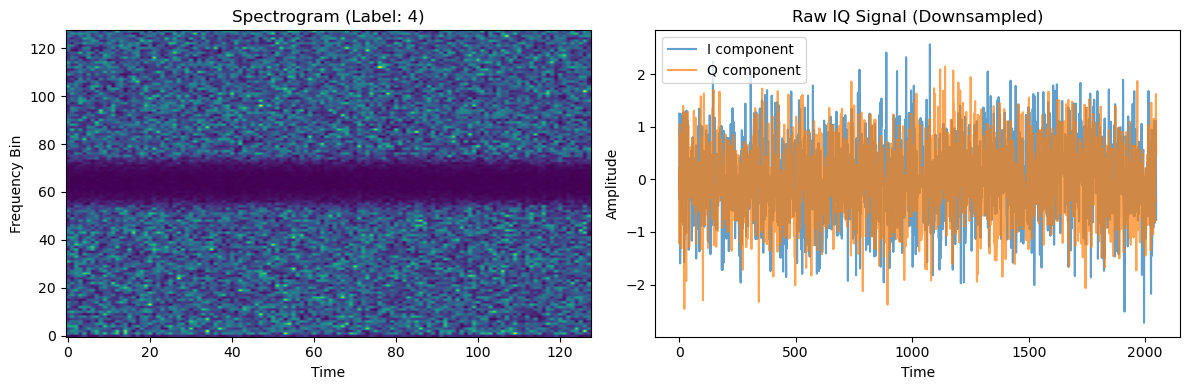

Initializing LSNetLSTMNet (Project Demo Version)...
Initializing LSNetLSTMNet (Project Demo Version)...
Starting Flower simulation for 10 rounds...


2025-11-06 06:38:42,399	INFO worker.py:1771 -- Started a local Ray instance.


(ClientAppActor pid=26891) Initializing LSNetLSTMNet (Project Demo Version)...


(ClientAppActor pid=26891) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26891) 
(ClientAppActor pid=26891)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26891)             entirely in future versions of Flower.
(ClientAppActor pid=26891)         


Server-side evaluation round 0 / 10: Loss 2.0683 | Acc 0.1334
✅ Best model saved (Acc=0.1334)
(ClientAppActor pid=26891) Initializing LSNetLSTMNet (Project Demo Version)...


(ClientAppActor pid=26891) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26891) 
(ClientAppActor pid=26891)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26891)             entirely in future versions of Flower.
(ClientAppActor pid=26891)         
(ClientAppActor pid=26894) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26894) 
(ClientAppActor pid=26894)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26894)             entirely in future versions of Flower.
(ClientAppActor pid=2689

(ClientAppActor pid=26892) Initializing LSNetLSTMNet (Project Demo Version)...


In [ ]:
# ==============================================================================
# === Cell 4: Run the Simulation (Training) ===
# ==============================================================================
# (This cell starts and runs the entire federated training process)

# --- [NEW] Display a sample from the Training Set ---
print("--- Displaying one sample from Training Client 0 ---")
try:
    train_sample_ds = H5RFShard(TRAIN_CLIENT_PATHS["0"], downsample=DOWNSAMPLE, transform=None)
    train_sample = train_sample_ds[0] # Get the first sample
    plot_sample(train_sample)
except Exception as e:
    print(f"Could not load or plot training sample: {e}")
# ----------------------------------------------------


# [CRITICAL] Instantiate the LSNetLSTMNet class for the server
server_model = LSNetLSTMNet(num_classes=NUM_CLASSES).to(DEVICE)

# Create the server-side function
eval_fn = get_evaluate_fn(
    model_class=LSNetLSTMNet, # Pass the *class*
    test_h5=GLOBAL_TEST_H5_PATH,
    batch_size=BATCH_SIZE,
    downsample=DOWNSAMPLE,
    device=DEVICE,
    out_dir=OUT_DIR,
    num_rounds=NUM_ROUNDS,
    num_classes=NUM_CLASSES
)

# Define the strategy (Standard FedAvg)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS, # This is 4
    min_evaluate_clients=NUM_CLIENTS, # This is 4
    min_available_clients=NUM_CLIENTS, # This is 4
    evaluate_fn=eval_fn
)

# Add client_resources to prevent OOM errors
ray_init_args = {"num_gpus": 1}
# [MODIFIED] 0.25 * 4 clients = 1.0 GPU
client_resources = {"num_cpus": 1, "num_gpus": 0.25} 

print(f"Starting Flower simulation for {NUM_ROUNDS} rounds...")
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS, # This is 4
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args=ray_init_args
)
print("Simulation finished.")


--- Starting Final Evaluation ---
Loading best model from: /Users/rhithik/Desktop/project_new/fl_output_notebook_unpoisoned/global_model_best.pth
Evaluating on data from: /Volumes/others/data/client4.h5
Initializing LSNetLSTMNet (Project Demo Version)...

--- Displaying 5 samples from Test Client 4 ---

--- Test Sample 1/5 ---


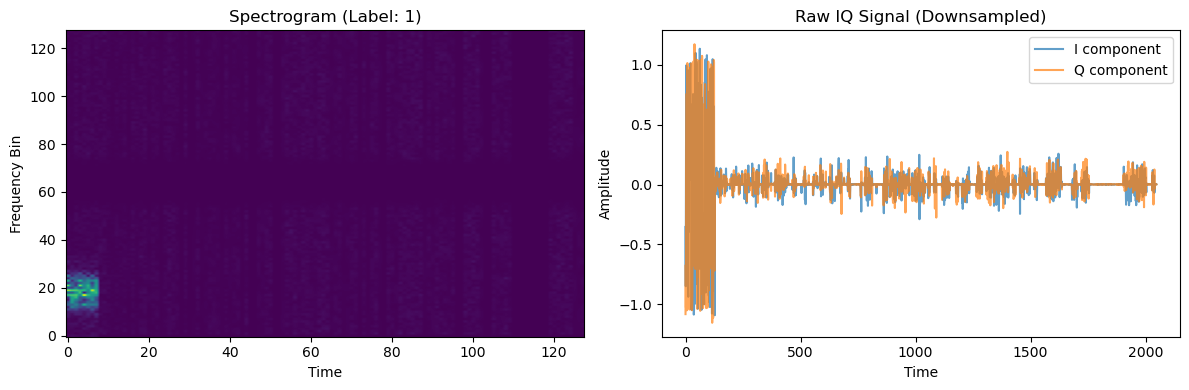

  True Label:     1
  Predicted Label: 1
  Result: ✅ Correct
------------------------------

--- Test Sample 2/5 ---


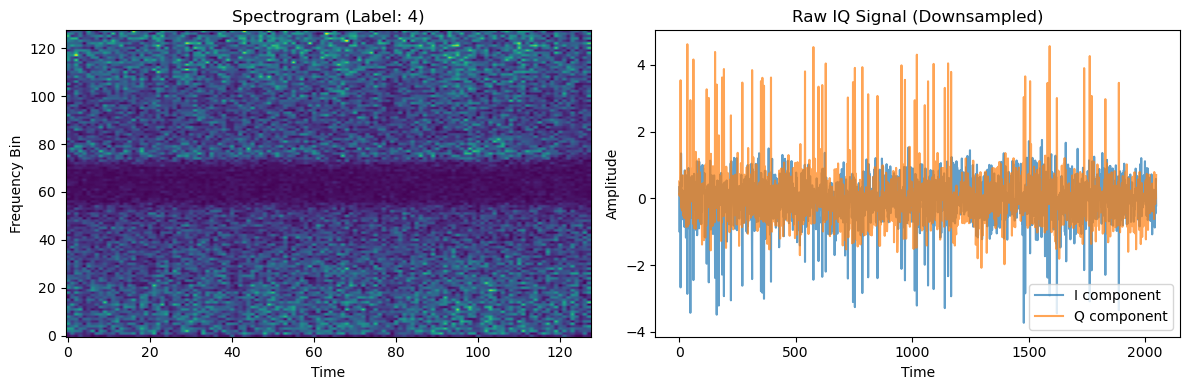

  True Label:     4
  Predicted Label: 6
  Result: ❌ Incorrect
------------------------------

--- Test Sample 3/5 ---


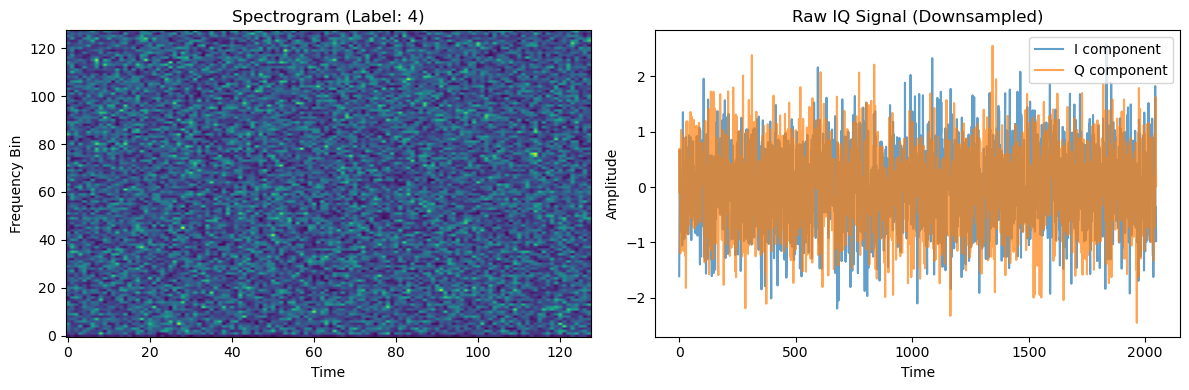

  True Label:     4
  Predicted Label: 4
  Result: ✅ Correct
------------------------------

--- Test Sample 4/5 ---


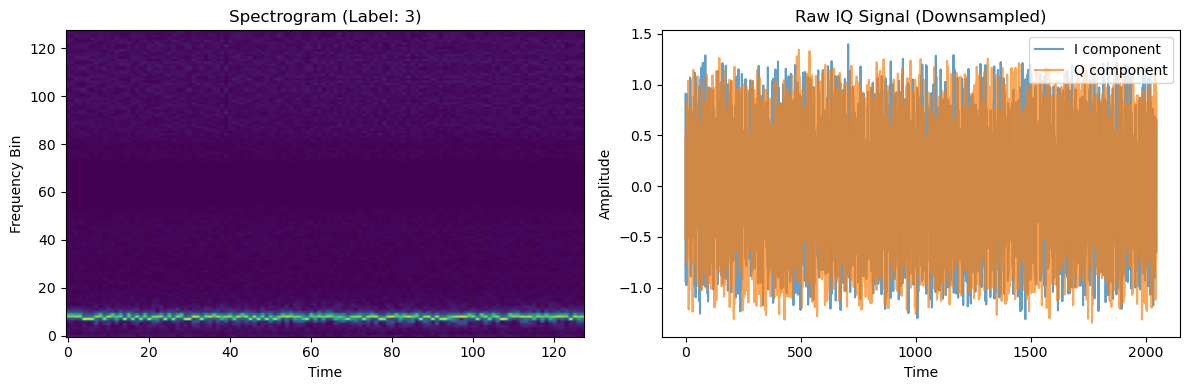

  True Label:     3
  Predicted Label: 3
  Result: ✅ Correct
------------------------------

--- Test Sample 5/5 ---


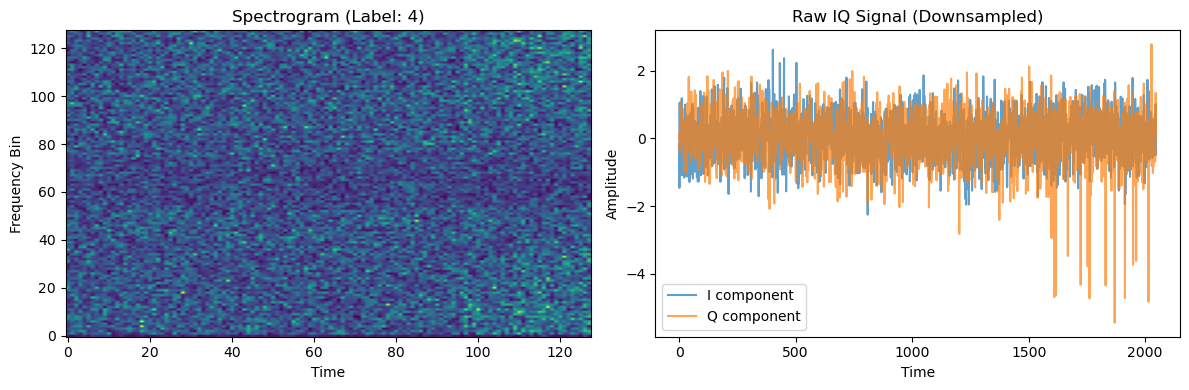

  True Label:     4
  Predicted Label: 4
  Result: ✅ Correct
------------------------------

--- Final Global Model Evaluation ---
Test Loss: 0.5199
Test Accuracy: 0.9098

Classification report:
               precision    recall  f1-score   support

           0     0.8583    0.7749    0.8144       422
           1     0.9180    0.8074    0.8592      1428
           2     0.8222    0.7638    0.7919       690
           3     0.9823    0.8689    0.9221      1281
           4     0.9054    0.9565    0.9302     10593
           5     0.9734    0.9242    0.9482      3246
           6     0.8303    0.8208    0.8255      2081

    accuracy                         0.9098     19741
   macro avg     0.8986    0.8452    0.8702     19741
weighted avg     0.9106    0.9098    0.9092     19741

Confusion matrix saved to ./fl_output_notebook/confusion_matrix.png
SNR vs. Accuracy plot saved to ./fl_output_notebook/snr_vs_accuracy.png

Evaluation complete. Plots saved to ./fl_output_notebook
No 'histo

In [9]:
# ==============================================================================
# === Cell 5: Evaluate the Final Model ===
# ==============================================================================
# (This cell loads the saved model and runs a full evaluation)

# --- Configuration for evaluation ---
MODEL_PATH = os.path.join("/Users/rhithik/Desktop/project_new/fl_output_notebook_unpoisoned", "global_model_best.pth") # Load best model
EVAL_H5_PATH = GLOBAL_TEST_H5_PATH # Evaluate on the held-out test client
NUM_SAMPLES_TO_SHOW = 5 # <-- [NEW] Show 5 samples
# --------------------------------------


print(f"\n--- Starting Final Evaluation ---")
print(f"Loading best model from: {MODEL_PATH}")
print(f"Evaluating on data from: {EVAL_H5_PATH}")

# [CRITICAL] Initialize the LSNetLSTMNet class
final_model = LSNetLSTMNet(num_classes=NUM_CLASSES)

# 2. Load saved weights
try:
    final_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    final_model.to(DEVICE)
    final_model.eval() # Set model to evaluation mode

    # --- [MODIFIED] Display multiple samples from the Test Set ---
    print(f"\n--- Displaying {NUM_SAMPLES_TO_SHOW} samples from Test Client {TEST_CLIENT_ID} ---")
    
    # Load the test dataset
    test_sample_ds = H5RFShard(EVAL_H5_PATH, downsample=DOWNSAMPLE, transform=None)
    
    for i in range(NUM_SAMPLES_TO_SHOW):
        print(f"\n--- Test Sample {i+1}/{NUM_SAMPLES_TO_SHOW} ---")
        test_sample = test_sample_ds[i]
        
        # 1. Plot the sample
        plot_sample(test_sample)
        
        # 2. Predict on the single test sample
        # Get the sample tensors, add batch dim, and send to device
        sample_iq = test_sample["iq"].unsqueeze(0).to(DEVICE)
        sample_spec = test_sample["spec"].unsqueeze(0).to(DEVICE)
        true_label = test_sample["label"].item()

        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
                logits = final_model(sample_iq, sample_spec)
                pred_label = logits.argmax(dim=1).item()
                
        print(f"  True Label:     {true_label}")
        print(f"  Predicted Label: {pred_label}")
        if true_label == pred_label:
            print("  Result: ✅ Correct")
        else:
            print("  Result: ❌ Incorrect")
        print("-" * 30)
    # --- End of sample display ---


    # 3. Run evaluation and plotting on the *entire* test set
    plot_confusion_and_report(
        model=final_model, 
        test_h5=EVAL_H5_PATH, 
        downsample=DOWNSAMPLE, 
        device=DEVICE, 
        out_dir=OUT_DIR
    )
    print(f"\nEvaluation complete. Plots saved to {OUT_DIR}")

except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}.")
    print("Please ensure the simulation in 'Cell 4' ran successfully and saved a model.")
except Exception as e:
    print(f"An error occurred during evaluation: {e}")

# --- [NEW] Plot Full Training History ---
if 'history' in locals():
    print("\nPlotting training history...")
    
    rounds = history.metrics_distributed["fit"].keys()
    if rounds:
        # --- Extract FIT metrics (Training) ---
        avg_train_loss = []
        avg_train_acc = []
        for r in rounds:
            # Get metrics from all clients in this round
            train_losses = [metrics.get("local_loss", 0.0) for cid, metrics in history.metrics_distributed["fit"][r]]
            train_accs = [metrics.get("train_acc", 0.0) for cid, metrics in history.metrics_distributed["fit"][r]]
            
            # Calculate averages
            avg_train_loss.append(np.mean(train_losses) if train_losses else np.nan)
            avg_train_acc.append(np.mean(train_accs) if train_accs else np.nan)

        # --- Extract EVALUATE metrics (Local Validation) ---
        avg_val_acc = []
        for r in rounds:
            # Get metrics from all clients in this round
            if r in history.metrics_distributed["evaluate"]:
                val_accs = [metrics["accuracy"] for cid, metrics in history.metrics_distributed["evaluate"][r]]
                avg_val_acc.append(np.mean(val_accs) if val_accs else np.nan)
            else:
                avg_val_acc.append(np.nan)
            
        # --- Extract EVALUATE metrics (Global Test) ---
        if "evaluate" in history.metrics_centralized and history.metrics_centralized["evaluate"]:
            global_acc_hist = [metrics["accuracy"] for r, metrics in history.metrics_centralized["evaluate"]]
            
            # --- Create 2x2 Plot Grid ---
            plt.figure(figsize=(12, 10))

            # Plot 1: Avg. Client Training Loss
            plt.subplot(2, 2, 1)
            plt.plot(rounds, avg_train_loss, marker='o', color='C0')
            plt.title("Average Client Training Loss per Round")
            plt.xlabel("Round"); plt.ylabel("Loss"); plt.grid(True)

            # Plot 2: Avg. Client Training Accuracy
            plt.subplot(2, 2, 2)
            plt.plot(rounds, avg_train_acc, marker='o', color='C1')
            plt.title("Average Client Training Accuracy per Round")
            plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.grid(True)
            
            # Plot 3: Avg. Client Validation Accuracy
            plt.subplot(2, 2, 3)
            plt.plot(rounds, avg_val_acc, marker='o', color='C2')
            plt.title("Average Client Validation Accuracy per Round")
            plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.grid(True)

            # Plot 4: Global Test Accuracy
            plt.subplot(2, 2, 4)
            plt.plot(rounds, global_acc_hist, marker='o', color='C4')
            plt.title("Global Test Accuracy per Round (on held-out client)")
            plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        else:
            print("No centralized evaluation metrics found in history.")
    else:
        print("No fit metrics found in history.")
else:
    print("No 'history' object found. Skipping training plots.")